In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import xlrd
import os
import fiona
from statistics import mean, median
import string
import math
import re

from shapely.geometry import Polygon
from shapely.ops import cascaded_union

pd.set_option('display.max_rows', 200)

# VEST IA 2020

## VEST Documentation

### Sources

Election results from Iowa Secretary of State (https://sos.iowa.gov/elections/results/index.html)<br>
Precinct shapefile primarily from IA Secretary of State (https://sos.iowa.gov/shapefiles/)

### Shapefiles

The following counties instead use shapefiles sourced from the respective county governments: Dallas, Dubuque, Johnson, Linn, Polk, Pottawattamie, Scott, Story. The following counties were aligned with updated municipal boundaries from the U.S. Census Bureau's 2020 Redistricting Data Program: Marion, Muscatine, Woodbury. Mitchell County was edited to match the revised 2020 precinct map from the county.

The following precincts were merged to match the 2020 general election results.

Appanoose: Udell/Union<br>
Black Hawk: Cedar Falls W2P2/Cedar Falls Twp<br>
Cass: Atlantic 1/BR-GV-WS-PY, Atlantic 2/3, 4/5, BN-FR/GN-LN<br>
Davis: Bloomfield 1/2/3<br>
Des Moines: Burlington 1/Tama, Burlington 8/Concordia<br>
Fremont: Hamburg/Washington, Farragut/Shenandoah1<br>
Henry: Mt Pleasant 1/2/3/4<br>
Howard: Cresco 1/2/3<br>
Lee: Fort Madison 4A/4B, Keokuk 2A/2B, FCM/Harrison<br>
Mitchell: Precinct 1/12, 3/10/11, 5/6, 7/8/9<br>
Polk: Grimes 2/Urbandale 12<br>
Tama: Toledo 1/2/3<br>

### Races

G20PRERTRU - Donald J. Trump (Republican Party)<br>
G20PREDBID - Joseph R. Biden (Democratic Party)<br>
G20PRELJOR - Jo Jorgensen (Libertarian Party)<br>
G20PREGHAW - Howie Hawkins (Green Party)<br>
G20PRECBLA - Don Blakenship (Constitution Party)<br>
G20PREOFUE - Roque Rocky De La Fuente (Alliance Party)<br>
G20PREOKIN - Ricki Sue King (Genealogy Know Your Family History Party)<br>
G20PREIWES - Kanye West (Independent)<br>
G20PREIPIE - Brock Pierce (Independent)<br>
G20PREOWRI - Write-in Votes<br>
<br>
G20USSRERN - Joni Ernst (Republican Party)<br>
G20USSDGRE - Theresa Greenfield (Democratic Party)<br>
G20USSLSTE - Rick Stewart (Libertarian Party)<br>
G20USSOHER - Suzanne Herzog (Independent)<br>
G20USSOWRI - Write-in Votes<br>

## Load in VEST file

In [2]:
vest_ia_2020 = gp.read_file("./raw-from-source/VEST/ia_2020/ia_2020.shp")

<AxesSubplot:>

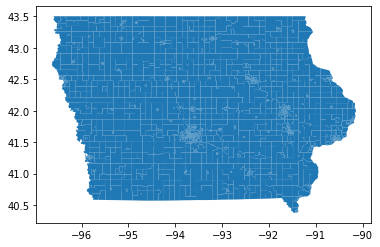

In [3]:
vest_ia_2020.plot()

In [4]:
vest_ia_2020.columns

Index(['COUNTY', 'DISTRICT', 'NAME', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGHAW', 'G20PRECBLA', 'G20PREOFUE', 'G20PREOKIN', 'G20PREIWES',
       'G20PREIPIE', 'G20PREOWRI', 'G20USSRERN', 'G20USSDGRE', 'G20USSLSTE',
       'G20USSOHER', 'G20USSOWRI', 'geometry'],
      dtype='object')

## Build table of precinct-level election results from IA SOS Spreadsheets

Notes:
- Scott.xlsx does not open -- maybe try downloading it again?
    - it's a PDF... needs to be digitized.
- Each candidate has three columns of votes for each precinct: 
    - Election Day votes
    - Absentee votes
    - Total votes

In [5]:
ER_INPUT_DIR = './raw-from-source/Election_Results/'

In [6]:
# outputs the number of columns in each county's presidential results page. 

col_counts = []

RUN_CHECK = False

if RUN_CHECK:
    ER_INPUT_DIR = './raw-from-source/Election_Results/'
    input_files = os.listdir(ER_INPUT_DIR)
    # temp files associated with open excel spreadsheets start with "~$"
    for fn in list(filter(lambda e: e.endswith('.xlsx') and not e.startswith('~$'), input_files)):
        county_name = fn.strip('.xlsx')
        xls_sheets = pd.read_excel(os.path.join(ER_INPUT_DIR, fn), sheet_name=['2', '3'], skiprows=1)
        pres_xls = xls_sheets['2']
        column_count = len(list(pres_xls.loc[0]))
        col_counts.append({'County': county_name, 'Columns': column_count})
        
    col_counts_df = pd.DataFrame.from_records(col_counts)
    col_counts_df.to_csv('./pres_col_counts.csv', index=False)

In [7]:
pres_labels_to_vest = {
    'Donald J. Trump and Michael R. Pence': 'G20PRERTRU',
    'Joseph R. Biden and Kamala D. Harris': 'G20PREDBID',
    'Jo Jorgensen and Jeremy Cohen': 'G20PRELJOR',
    'Howie Hawkins and Angela Nicole Walker': 'G20PREGHAW',
    'Don Blankenship and William Alan Mohr': 'G20PRECBLA',
    'Roque Rocky De La Fuente and Darcy G. Richardson': 'G20PREOFUE',
    'Ricki Sue King and Dayna R. Chandler': 'G20PREOKIN',
    'Kanye West and Michelle Tidball': 'G20PREIWES',
    'Brock Pierce and Karla Ballard': 'G20PREIPIE',
    'Write-in': 'G20PREOWRI'
}

sen_labels_to_vest = {
    'Joni Ernst': 'G20USSRERN',
    'Theresa Greenfield': 'G20USSDGRE',
    'Rick Stewart': 'G20USSLSTE',
    'Suzanne Herzog': 'G20USSOHER',
    'Write-in': 'G20USSOWRI'
}

Builds a cleaned dataframe of precinct results for a given county from its SOS spreadsheet. Works for both raw presidential and senate sheets.

In [8]:
def build_results_dataframe(county_pres_xls, county_name):
    column_count = len(list(county_pres_xls.loc[0]))
    
    # Label the precinct row, and drop the registered voters and total votes columns. 
    #
    # The 1st (zero-indexed) and right-most column contain registered voters and total information respectively,
    # Registered voters column is unreliable, and total can be re-calculated, so throw them both out now. 
    county_pres_xls.at[0, 'Unnamed: 0'] = 'Precinct'
    rhs_col_label = 'Unnamed: {0}'.format(column_count-1)
    county_pres_xls = county_pres_xls.drop(columns = ['Unnamed: 1', rhs_col_label])

    # extract the list of candidates in this table by filtering out the "Unnamed: N" values in the column labels.
    column_labels = list(county_pres_xls.columns)
    candidates = [e for e in column_labels if not e.startswith('Unnamed:')]

    # expand the names of the candidates to span each of the three "vote type" columns which contain their results
    new_candidate_row = ['Precinct']
    for candidate_name in candidates:
        new_candidate_row += [candidate_name, candidate_name, candidate_name]
    county_pres_xls.columns = new_candidate_row

    # separate the precinct results from the vote-type columns so we can re-apply this information correctly as a multi-index. 
    results_df = county_pres_xls.loc[1:len(pres_xls)-2].copy(deep=True)
    
    # add a county row
    results_df['County'] = county_name

    # Clean the precinct column and make the county & precinct this table's index
    results_df['Precinct'] = results_df['Precinct'].apply(lambda e: e.strip())
    results_df = results_df.set_index(['County', 'Precinct'])
    
    # Create a MultiIndexed column header so we can include candidate names and vote types all in one row. 
    results_df.columns = pd.MultiIndex.from_product([candidates, ['Election Day', 'Absentee', 'Total Votes']])

    # We can move the "vote type" dimension of this data to its own column with .stack()
    results_df = results_df.stack()
    results_df.index = results_df.index.rename(['County', 'Precinct', 'Vote Type'])

    # Drop the "total votes" vote type. 
    results_df = results_df.drop('Total Votes', level=2, axis=0)

    # apply a consistent ordering of the candidate columns
    results_df = results_df[list(candidates)]    
    return results_df

Extract the presidential and senate data from each county's spreadsheets, merge it all into one file, and write it to disk.

In [9]:
county_results = {}

SHOULD_PROCESS_INPUT_DATA = True

if SHOULD_PROCESS_INPUT_DATA:
    input_files = os.listdir(ER_INPUT_DIR)
    # temp files associated with open excel spreadsheets start with "~$"
    for fn in list(filter(lambda e: e.endswith('.xlsx') and not e.startswith('~$'), input_files)):
        county_name = fn.strip('.xlsx')
        xls_sheets = pd.read_excel(os.path.join(ER_INPUT_DIR, fn), sheet_name=['2', '3'], skiprows=1)
        
        # Presidential results are in tables on separate sheets (pres = '2', senate = '3'). 
        pres_xls = xls_sheets['2']
        senate_xls = xls_sheets['3']
        
        # Build cleaned dataframes from the raw results
        pres_df = build_results_dataframe(pres_xls, county_name)
        senate_df = build_results_dataframe(senate_xls, county_name)
        
        # standardize senate and presidential candidate names by replacing w/ their vest IDs
        pres_df.columns = list(map(lambda e: pres_labels_to_vest[e], list(pres_df.columns)))
        senate_df.columns = list(map(lambda e: sen_labels_to_vest[e], list(senate_df.columns)))

        # join the presidential and senate results, using the presidential frame as a base.
        county_res_df = pres_df.merge(senate_df, how='outer', left_on=['County', 'Precinct', 'Vote Type'], right_on=['County', 'Precinct', 'Vote Type'])
        county_results[county_name] = county_res_df
        
    # add in Scott county's digitized precinct results
    scott_pres_df = pd.read_csv(os.path.join(ER_INPUT_DIR, 'scott-pres-digitized.csv'))
    scott_pres_df = scott_pres_df.set_index(['County', 'Precinct', 'Vote Type'])
    scott_sen_df = pd.read_csv(os.path.join(ER_INPUT_DIR, 'scott-sen-digitized.csv'))
    scott_sen_df = scott_sen_df.set_index(['County', 'Precinct', 'Vote Type'])
    scott_combined_df = scott_pres_df.merge(scott_sen_df, how='outer', left_on=['County', 'Precinct', 'Vote Type'], right_on=['County', 'Precinct', 'Vote Type'])
    county_results['Scott'] = scott_combined_df
    
    # combine each county's results together to create a single statewide precinct results datafile 
    all_results_df = pd.concat(list(county_results.values()), axis=0)
    all_results_df.to_csv('./ia-2020-statewide-precinct-results.csv')

## Load in Raw Election Results
NOTE: This is just the file we created in the "Build table of precinct-level election results from IA SOS Spreadsheets" section above.

In [10]:
results_df = pd.read_csv('./ia-2020-statewide-precinct-results.csv')

Group absentee and election day votes together so we can check statewide/countywide results.

In [13]:
er_2020_df = pd.read_csv('./ia-2020-statewide-precinct-results.csv')
er_2020_df = er_2020_df.sort_values(['County', 'Precinct'])
er_2020_df = er_2020_df.groupby(['County', 'Precinct']).sum()

## Validate statewide totals

In [16]:
races = list(pres_labels_to_vest.values()) + list(sen_labels_to_vest.values())

In [17]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [18]:
statewide_totals_check(vest_ia_2020, er_2020_df, races)

***Statewide Totals Check***
G20PRERTRU has a difference of -43683 votes
	VEST: 897672 votes
	SOURCES: 941355 votes
G20PREDBID has a difference of -46926 votes
	VEST: 759061 votes
	SOURCES: 805987 votes
G20PRELJOR has a difference of -1124 votes
	VEST: 19637 votes
	SOURCES: 20761 votes
G20PREGHAW has a difference of -209 votes
	VEST: 3075 votes
	SOURCES: 3284 votes
G20PRECBLA has a difference of -96 votes
	VEST: 1707 votes
	SOURCES: 1803 votes
G20PREOFUE has a difference of -51 votes
	VEST: 1082 votes
	SOURCES: 1133 votes
G20PREOKIN has a difference of -32 votes
	VEST: 546 votes
	SOURCES: 578 votes
G20PREIWES has a difference of -181 votes
	VEST: 3210 votes
	SOURCES: 3391 votes
G20PREIPIE has a difference of -22 votes
	VEST: 544 votes
	SOURCES: 566 votes
G20PREOWRI has a difference of -275 votes
	VEST: 4337 votes
	SOURCES: 4612 votes
G20USSRERN has a difference of -42941 votes
	VEST: 864997 votes
	SOURCES: 907938 votes
G20USSDGRE has a difference of -45751 votes
	VEST: 754859 votes
	SO